In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
IMG_SIZE = (100, 100)
BATCH_SIZE = 32
DATA_DIR = "/content/fruit_subset_100"  # Adjust this path if needed

import zipfile

with zipfile.ZipFile("fruit_subset_100.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fruit_subset_100")

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])


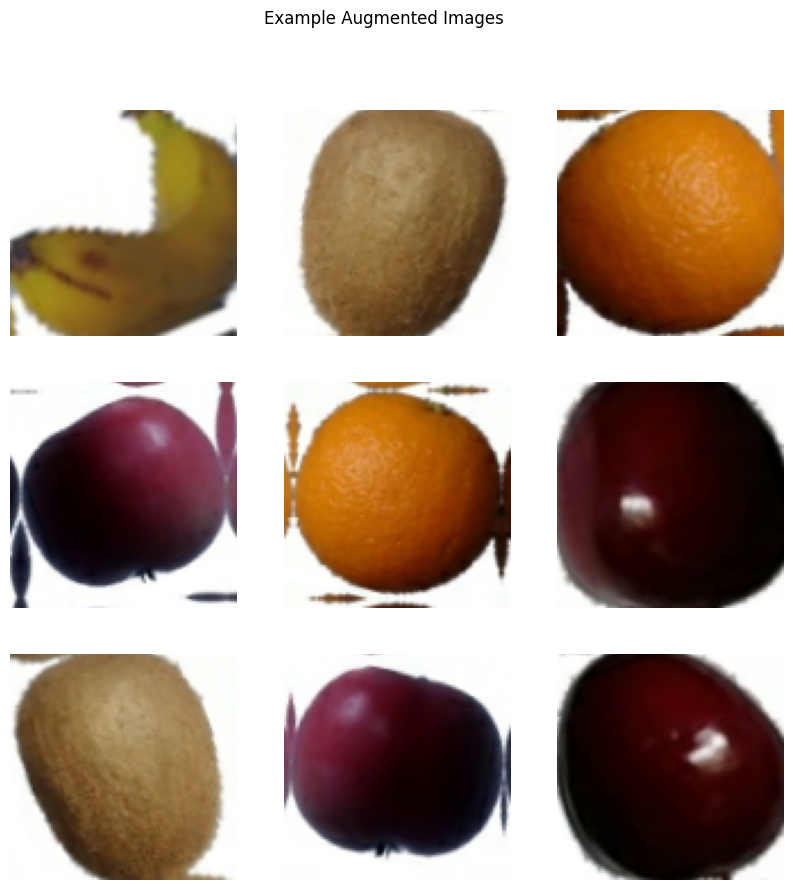

In [6]:
# Visualize 9 augmented images
import matplotlib.pyplot as plt

for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.suptitle("Example Augmented Images")
    plt.show()


In [7]:
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)  # Adjust 5 if needed
model = tf.keras.Model(inputs, outputs)


In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7328 - loss: 0.8523 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9869 - loss: 0.0253 - val_accuracy: 1.0000 - val_loss: 1.3937e-04
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9974 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 3.2360e-05
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 9.4592e-04 - val_accuracy: 1.0000 - val_loss: 3.6240e-05
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 7.2422e-04 - val_accuracy: 1.0000 - val_loss: 1.8830e-05
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 2.7362e-04 - val_accuracy: 1.0000 - val_loss: 1.7700e-05
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 4.2585e-04 - val_accuracy: 1.0000 - val_loss: 1.6183e-05
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 3

In [11]:
model.save("resnet50_augmented.keras")


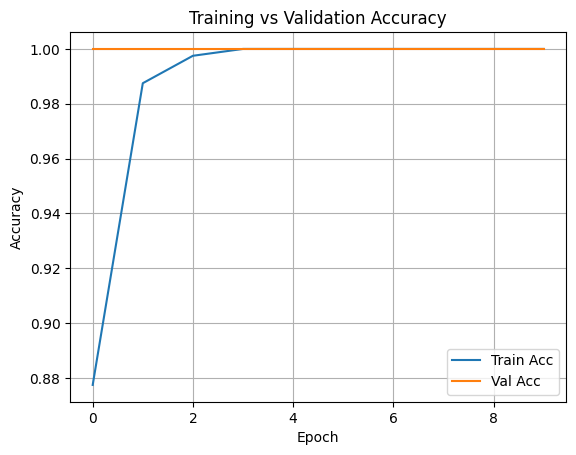

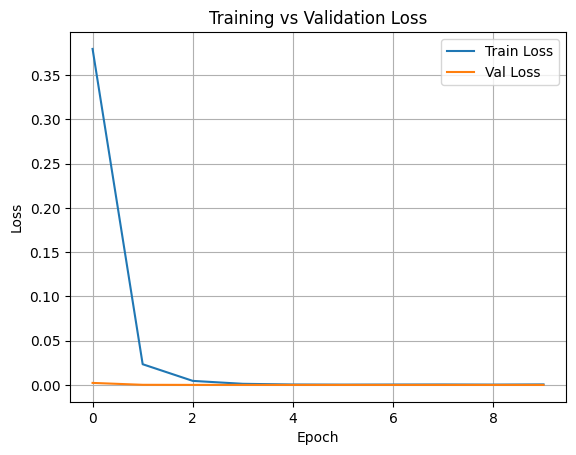

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


##Reflection

After training the ResNet50 model with data augmentation, the model reached 100% validation accuracy with significantly lower loss compared to the baseline. Augmentation included random flips, rotations, and zooms — which helped the model generalize better by reducing overfitting and increasing robustness to input variation.